<a href="https://colab.research.google.com/github/goshobhit123/AIMLProjects/blob/main/clip_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP from Scratch


**CLIP** or **Contrastive Language-Image Pre-training** is a model that learns the relationship between a whole sentence and the image it describes; in a sense that when the model is trained, given an input sentence it will be able to retrieve the most related images corresponding to that sentence. The important thing here is that it is trained on full sentences instead of single classes like car, dog, etc. The intuition is that when trained on whole sentences, the model can learn a lot more things and finds some pattern between images and texts.
They also show that when this model is trained on a huge dataset of images and their corresponding texts, it can also act as a classifier too. I encourage you to study the paper to learn more about this exciting model and their astonishing results on benchmarking datasets . To mention just one, CLIP model trained with this strategy classifies ImageNet better than those SOTA models trained on the ImageNet itself optimized for the only task of classification!

As a **teaser**, let's see what the final model that we will build in this article from scratch is capable of: given a query (raw text) like "a boy jumping with skateboard" or "a girl jumping from swing", the model will retrieve the most relevant images:

![](https://i.ibb.co/9gdYqNP/teaser-cropped.png)

In this notebook, we will see how to implement CLIP from Scratch

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.9 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

<ipython-input-5-2540d8c9d86b>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Some pre-preocessing

In [ ]:
# --- NEW MODIFIED Pre-processing for Flickr8k (REPLACE THE ENTIRE PREVIOUS BLOCK) ---
import pandas as pd
import os
import numpy as np

# Define your base Flickr8k dataset path on Google Drive
base_flickr8k_path = "/content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/flickr8k"
flickr8k_captions_file = os.path.join(base_flickr8k_path, "captions.txt")

print(f"Attempting to read captions from: {flickr8k_captions_file}")

# Check if the captions file actually exists
if not os.path.exists(flickr8k_captions_file):
    print(f"Error: Captions file not found at {flickr8k_captions_file}")
    raise FileNotFoundError(f"Captions file not found: {flickr8k_captions_file}")

# Read the Flickr8k captions.txt directly as a CSV
# Assuming it has two columns: 'image' and 'caption', separated by a comma.
try:
    df = pd.read_csv(flickr8k_captions_file, delimiter=',')
    # Ensure column names are as expected (lowercase 'image', 'caption')
    df.columns = ['image', 'caption']
    print("Successfully loaded captions.txt as a CSV.")
except Exception as e:
    print(f"Error reading captions.txt as CSV: {e}")
    print("Please check if your captions.txt is indeed comma-separated and has 'image,caption' header.")
    raise

# Now, generate 'caption_number' and 'id' columns as per the Kaggle notebook's expected structure.
# Each image typically has 5 captions.
image_counts = df['image'].value_counts()
# Filter out images that don't have exactly 5 captions if necessary, or adjust logic if your dataset varies
# For simplicity, we'll assume most have 5 and create caption numbers accordingly.

# Create 'caption_number' based on the order of captions for each image
df['caption_number'] = df.groupby('image').cumcount()

# Create 'id' column for unique images
image_ids = df['image'].unique()
image_id_map = {img_name: i for i, img_name in enumerate(image_ids)}
df['id'] = df['image'].map(image_id_map)

# Save the processed dataframe to captions.csv in your base_flickr8k_path
# This 'captions.csv' will be used by make_train_valid_dfs
output_captions_csv_path = os.path.join(base_flickr8k_path, "captions.csv")
df.to_csv(output_captions_csv_path, index=False)
print(f"Processed Flickr8k captions saved to: {output_captions_csv_path}")

print("\nDataFrame head after processing:")
print(df.head())
# --- END NEW MODIFIED Pre-processing ---

Attempting to read captions from: /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/flickr8k/captions.txt
Successfully loaded captions.txt as a CSV.
Processed Flickr8k captions saved to: /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/flickr8k/captions.csv

DataFrame head after processing:
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  caption_number  id  
0  A child in a pink dress is climbing up a set o...               0   0  
1              A girl going into a wooden building .               1   0  
2   A little girl climbing into a wooden playhouse .               2   0  
3  A little girl climbing the stairs to her playh...               3   0  
4  A little girl in a pink dress going into a woo...               4   0  


## Config

In [ ]:
##Config

class CFG:
    debug = False # Set to True for faster testing on a small subset (e.g., max_id in make_train_valid_dfs will be 100)
    # --- MODIFIED Paths (REPLACE THESE LINES) ---
    image_path = os.path.join(base_flickr8k_path, "Images") # Path to your Flickr8k Images folder
    captions_path = base_flickr8k_path # Path to where captions.csv was saved (i.e., base_flickr8k_path)
    # --- END MODIFIED Paths ---

    batch_size = 64
    num_workers = 4 # Adjust based on your Colab runtime (0 for less memory, but slower data loading)
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 2 # Consider increasing for better performance (e.g., 5-10)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model_name = 'resnet50'
    image_embedding = 2048 # ResNet50 typically outputs 2048 features
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768 # DistilBERT base model outputs 768 features
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1
cfg = CFG()

## Utils

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

We need to encode both images and their describing texts. We use **Flickr 30k** dataset that contains 31.8k images and caption pairs.

We will use **DistilBERT** model (which is smaller than BERT but performs nearly as well as BERT) from **HuggingFace** library as our text encoder; so, we need to **tokenize** the sentences (captions) with DistilBERT tokenizer and then feed the token ids (input_ids) and the attention masks to DistilBERT. Therefore, the dataset needs to take care of the tokenization as well. Below you can see the dataset's code. Below that I'll explain the most important things that is happening in the code.

In the **\_\_init\_\_** we receive a tokenizer object which is actually a HuggingFace tokinzer; this tokenizer will be loaded when running the model. We are padding and truncating the captions to a specified max_length. In the **\_\_getitem\_\_** we will first load an encoded caption which is a dictionary with keys input_ids and attention_mask, make tensors out of its values and after that we will load the corresponding image, transform and augment it (if there is any!) and then we make it a tensor and put it in the dictionary with "image" as the key. Finally we put the raw text of the caption with the key "caption" in the dictionary only for visualization purposes.

I did not use additional data augmentations but you can add them if you want to improve the model's performance.

In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=cfg.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{cfg.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(cfg.size, cfg.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(cfg.size, cfg.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

The image encoder code is straight forward. I'm using PyTorch Image Models library (timm) here which makes a lot of different image models available from ResNets to EfficientNets and many more. Here we will use a ResNet50 as our image encoder. You can easily use torchvision library to use ResNets if you don't want to install a new library.

The code encodes each image to a fixed size vector with the size of the model's output channels (in case of ResNet50 the vector size will be **2048**). This is the output after the nn.AdaptiveAvgPool2d() layer.

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=cfg.model_name, pretrained=cfg.pretrained, trainable=cfg.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

I'll use DistilBERT as the text encoder. Like its bigger brother BERT, two special tokens will be added to the actual input tokens: **CLS** and **SEP** which mark the start and end of a sentence. To grab the whole representation of a sentence (as the related BERT and DistilBERT papers point out) we use the final representations of the CLS token and we hope that this representation captures the overall meaning of the sentence (caption). Thinking it in this way, it is similar to what we did to images and converted them into a fixed size vector.

In the case of DistilBERT (and also BERT) the output hidden representation for each token is a vector with size **768**. So, the whole caption will be encoded in the CLS token representation whose size is 768.

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=cfg.text_encoder_model, pretrained=cfg.pretrained, trainable=cfg.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

Now that we have encoded both our images and texts into fixed size vectors (2048 for image and 768 for text) we need to bring (project) them into a _new world_ with **similar dimensions** for both images and texts in order to be able to compare them and push apart the non-relevant image and texts and pull together those that match. So, the following code will bring the 2048 and 768 dimensional vectors into a 256 (projection_dim) dimensional world, where we can **compare** them.

"embedding_dim" is the size of the input vector (2048 for images and 768 for texts) and "projection_dim" is the the size of the output vector which will be 256 for our case. For understanding the details of this part you can refer to the CLIP paper.

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=cfg.projection_dim,
        dropout=cfg.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

![clip.png](attachment:fb0403a4-73b2-4b97-bfec-c824d11677ee.png)

Here we will use the previous modules that we built to implement the main model. The \_\_init\_\_ function is self-explanatory. In the forward function, we first encode the images and texts separately into fixed size vectors (with different dimensionalities). After that, using separate projection modules we project them to that shared world (space) that I talked about previously. Here the encodings will become of similar shape (256 in our case). After that we will compute the loss. Again I recommend reading CLIP paper to get it better but I'll try my best to explain this part.

In Linear Algebra, one common way to measure if two vectors are of similar characteristics (they are like each other) is to calculate their **dot product** (multiplying the matching entries and take the sum of them); if the final number is big, they are alike and if it is small they are not (relatively speaking)!

Let's now understand the loss function. We talked about two vectors, but, what do we have here? We have image_embeddings, a matrix with shape (batch_size, 256) and text_embeddings with shape (batch_size, 256). It means we have two groups of vectors instead of two single vectors. How do we measure how similar two groups of vectors (two matrices) are to each other? Again, with dot product (@ operator in PyTorch does the dot product or matrix multiplication in this case). To be able to multiply these two matrices together, we transpose the second one. Okay, we get a matrix with shape (batch_size, batch_size) which we will call logits. (temperature is equal to 1.0 in our case, so, it does not make a difference. You can play with it and see what difference it makes. Also look at the paper to see why it is here!).

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=cfg.temperature,
        image_embedding=cfg.image_embedding,
        text_embedding=cfg.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

So, in the best case scenario, text_embeddings and image_embedding matricies should be the same because they are describing similar things. Let's think now: if this happens, what would the logits matrix be like? Let's see with a simple example!

In [ ]:
# A simple Example

batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


So logits, in the best case, will be a matrix that if we take its softmax, will have 1.0s in the diagonal (An identity matrix to call it with fancy words!). As the loss function's job is to make model's predictions similar to targets (at least in most cases!), we want such a matrix as our target. That's the reason why we are calculating images_similarity and texts_similarity matrices in the code block above.

Now that we've got our targets matrix, we will use simple cross entropy to calculate the actual loss. I've written the full matrix form of cross entropy as a function which you can see in the bottom of the code block.

There's a simpler way to calculate this loss in PyTorch; by doing this: nn.CrossEntropyLoss()(logits, torch.arange(batch_size)). The reason of not using that here is that the dataset we are using has multiple captions for a single image; so, there is the possibility that two identical images with their similar captions exist in a batch (it is rare but it can happen). Taking the loss with this easier method will ignore this possibility and the model learns to pull apart two representations (assume them different)  that are actually the same. Obviously, we don't want this to happen so I calculated the whole target matrix in a way that takes care of these edge cases.

## Train

Here are some funtions to help us load train and valid dataloaders, our model and then train and evaluate our model on those. There's not much going on here; just simple training loop and utility functions

In [ ]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{cfg.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not cfg.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

Here's a handy function to train our model. There's not much happening here; just loading the batches, feeding them to the model and stepping the optimizer and lr_scheduler.

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(cfg.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(cfg.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter



Running the next cell start training the model. Put the kernel on GPU mode. Every epoch should take about 24 minutes on GPU (even one epoch is enough!).

In [ ]:

train_df, valid_df = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

model = CLIPModel().to(CFG.device)

params = [
    {"params": model.image_encoder.parameters(), "lr": cfg.image_encoder_lr},
    {"params": model.text_encoder.parameters(), "lr": cfg.text_encoder_lr},
    {"params": itertools.chain(
        model.image_projection.parameters(), model.text_projection.parameters()
    ), "lr": cfg.head_lr, "weight_decay": cfg.weight_decay}
]
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=cfg.patience, factor=cfg.factor
)
step = "epoch"

best_loss = float('inf')
for epoch in range(cfg.epochs):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
    model.eval()
    with torch.no_grad():
        valid_loss = valid_epoch(model, valid_loader)

    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg

        # Define where you want to save your trained models on Google Drive
        output_model_path = '/content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model'
        os.makedirs(output_model_path, exist_ok=True) # Ensure the directory exists
        # Save Image Encoder
        torch.save(model.image_encoder.state_dict(), os.path.join(output_model_path, 'custom_image_encoder.pth'))
        print(f"Custom Image Encoder saved to: {os.path.join(output_model_path, 'custom_image_encoder.pth')}")
        # Save Text Encoder
        torch.save(model.text_encoder.state_dict(), os.path.join(output_model_path, 'custom_text_encoder.pth'))
        print(f"Custom Text Encoder saved to: {os.path.join(output_model_path, 'custom_text_encoder.pth')}")

        # Save Image Projection Head (Crucial for image embeddings and matching)
        torch.save(model.image_projection.state_dict(), os.path.join(output_model_path, 'custom_image_projection.pth'))
        print(f"Custom Image Projection Head saved to: {os.path.join(output_model_path, 'custom_image_projection.pth')}")

        # Save Text Projection Head (Crucial for text embeddings and matching)
        torch.save(model.text_projection.state_dict(), os.path.join(output_model_path, 'custom_text_projection.pth'))
        print(f"Custom Text Projection Head saved to: {os.path.join(output_model_path, 'custom_text_projection.pth')}")


        print(f"Saved Best Model to {output_model_path}!")
        lr_scheduler.step(valid_loss.avg)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

<ipython-input-9-05b97c75a63c>:40: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(cfg.size, cfg.size, always_apply=True),
<ipython-input-9-05b97c75a63c>:41: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(max_pixel_value=255.0, always_apply=True),
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-9-05b97c75a63c>:47: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(cfg.size, cfg.size, always_apply=True),
<ipython-input-9-05b97c75a63c>:48: UserWarning: Argum

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 1


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Custom Image Encoder saved to: /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model/custom_image_encoder.pth
Custom Text Encoder saved to: /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model/custom_text_encoder.pth
Custom Image Projection Head saved to: /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model/custom_image_projection.pth
Custom Text Projection Head saved to: /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model/custom_text_projection.pth
Saved Best Model to /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model!
Epoch: 2


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Custom Image Encoder saved to: /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model/custom_image_encoder.pth
Custom Text Encoder saved to: /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model/custom_text_encoder.pth
Custom Image Projection Head saved to: /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model/custom_image_projection.pth
Custom Text Projection Head saved to: /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model/custom_text_projection.pth
Saved Best Model to /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model!


## Inference

Okay! We are done with training the model. Now, we need to do inference which in our case will be giving the model a piece of text and want it to retrieve the most relevant images from an unseen validation (or test) set.

### Getting Image Embeddings

In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the image_embeddings with shape (valid_set_size, 256) and the model itself.

In [ ]:
##Getting Image Embeddings

# This path will be passed to get_image_embeddings
# trained_model_save_dir = '/content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model'

def get_image_embeddings(valid_df, saved_model_dir): # Changed parameter name for clarity
    tokenizer = DistilBertTokenizer.from_pretrained(cfg.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    # Instantiate the full CLIPModel
    model = CLIPModel().to(cfg.device)

    # Define paths for saved components
    image_encoder_path = os.path.join(saved_model_dir, 'custom_image_encoder.pth')
    image_projection_path = os.path.join(saved_model_dir, 'custom_image_projection.pth')
    text_encoder_path = os.path.join(saved_model_dir, 'custom_text_encoder.pth')
    text_projection_path = os.path.join(saved_model_dir, 'custom_text_projection.pth')

    # Load state_dicts for individual components into the model
    try:
        model.image_encoder.load_state_dict(torch.load(image_encoder_path, map_location=cfg.device))
        model.image_projection.load_state_dict(torch.load(image_projection_path, map_location=cfg.device))
        model.text_encoder.load_state_dict(torch.load(text_encoder_path, map_location=cfg.device))
        model.text_projection.load_state_dict(torch.load(text_projection_path, map_location=cfg.device))
        print(f"Loaded trained model components from {saved_model_dir}")
    except FileNotFoundError as e:
        print(f"Error loading saved model components: {e}")
        print("Please ensure you have saved 'custom_image_encoder.pth', 'custom_image_projection.pth', 'custom_text_encoder.pth', and 'custom_text_projection.pth' to the specified directory.")
        raise
    except RuntimeError as e:
        print(f"Error loading state dict: {e}")
        print("This might be due to a mismatch in model architecture and saved state_dict, or missing components.")
        raise

    model.eval() # Set the full model to evaluation mode

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            # Use the loaded components within the model
            image_features = model.image_encoder(batch["image"].to(cfg.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)

    return model, torch.cat(valid_image_embeddings)

In [ ]:
# Before the call to get_image_embeddings, define the path to your saved models
trained_model_save_dir = '/content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model'

_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, trained_model_save_dir)

<ipython-input-9-05b97c75a63c>:47: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(cfg.size, cfg.size, always_apply=True),
<ipython-input-9-05b97c75a63c>:48: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(max_pixel_value=255.0, always_apply=True),
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loaded trained model components from /content/drive/MyDrive/Multimodal-Media-Retrieval-Captioning/trained_clip_model


  0%|          | 0/127 [00:00<?, ?it/s]

### Finding Matches

This function does the final task that we wished our model would be capable of: it gets the model, image_embeddings, and a text query. It will display the most relevant images from the validation set! Isn't it amazing? Let's see how it performs.

In [ ]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(cfg.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(cfg.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{cfg.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

This is how we use this function. The results:

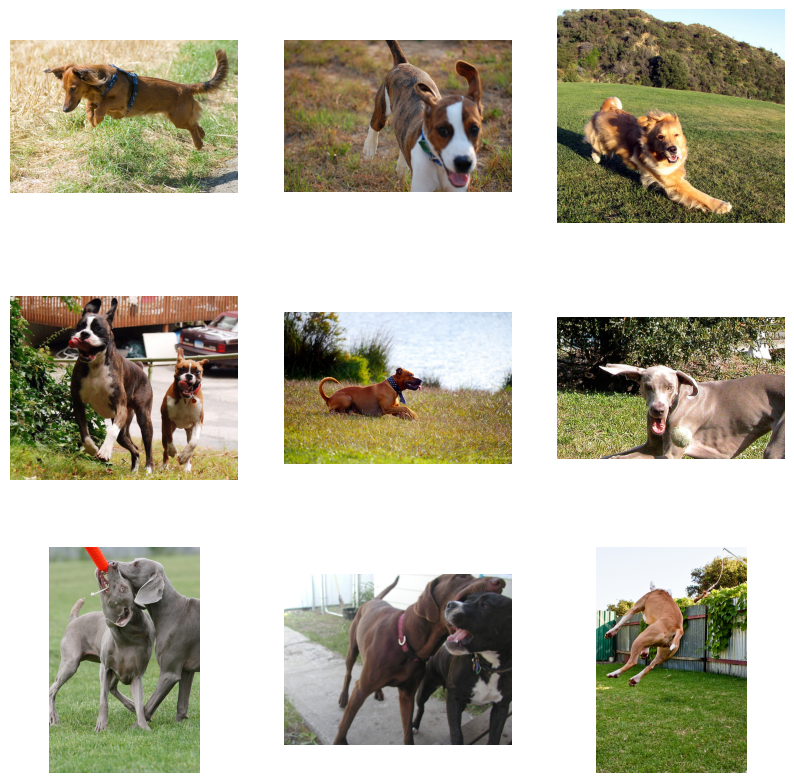

In [ ]:
find_matches(model,
             image_embeddings,
             query="one dog sitting on the grass",
             image_filenames=valid_df['image'].values,
             n=9)